# Academia

### Diagrama

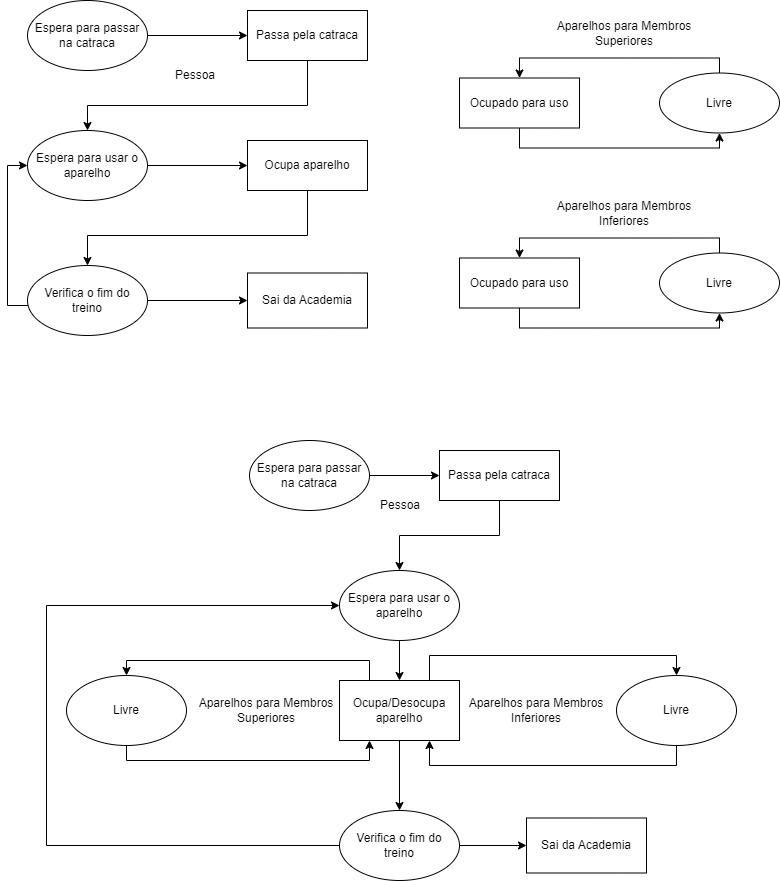

## Código

### Import Libs

In [3]:
import random
import simpy
import statistics
#import seaborn as sns
import pandas as pd
import time

from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [4]:
treinos = {0: 'costa', 1: 'bicep', 2: 'peito', 3: 'tricep', 4: 'abdomen', 5: 'perna'}
aparelhos = {}

In [13]:
class Pessoa():
    
    def __init__(self, tempo_treino=0) -> None:
        self.treino = []
        self.tempo_treino = tempo_treino
        
        self.tipos_aparelhos = {0: 'costa', 1: 'bicep', 2: 'peito', 3: 'tricep', 4: 'abdomen', 5: 'perna'}

    def montar_treino(self, quantidade_exercicios):
        for _ in range(quantidade_exercicios):
            self.treino.append(random.choice(list(self.tipos_aparelhos.keys())))
            
    def fazer_exercicio(self):
        treino = self.treino.pop(0)
        return (treino, self.tipos_aparelhos.get(treino))
    
    def get_treino(self):
        return self.treino

class Aparelho():
    
    def __init__(self, tipo_aparelho: list, qtd_aparelho, env) -> None:
        self.tipo_aparelho = tipo_aparelho
        self.qtd = qtd_aparelho

        self.tempo_ocupado = []
        self.ocioso = []
        self.utilizacao = 0
        self.ocupado = False
        
        self.resource = simpy.Resource(env, capacity=qtd_aparelho)
        self.tipos_aparelhos = {0: 'costa', 1: 'bicep', 2: 'peito', 3: 'tricep', 4: 'abdomen', 5: 'perna'}
    
    def get_tipo(self):
        return [self.tipos_aparelhos.get(x) for x in self.tipo_aparelho]
    
    def get_tempo(self):
        return self.tempo_ocupado
    
    def set_tempo(self, tempo):
        return self.tempo_ocupado.append(tempo)

    def add_util(self):
        self.utilizacao += 1
        return self.utilizacao
    
    def get_util(self):
        return self.utilizacao
    
    def get_ocup(self):
        return self.ocupado
    
    def set_ocup(self):
        self.ocupado = not self.ocupado
        return self.ocupado
    
    def set_ocioso(self, tempo):
        return self.ocioso.append(tempo)
    
    def get_ocioso(self):
        return self.ocioso
        
    def get_resource(self):
        return self.resource

In [12]:
test = Pessoa()
test.montar_treino(quantidade_exercicios=5)
print(test.treino)

[1, 3, 3, 2, 5]


In [60]:
def create_machines(qtd=2):
    for key,value in treinos.items():
        for _ in range(qtd):
            if key not in aparelhos.keys():
                aparelhos[key] = []
            aparelhos[key].append(Aparelho(value))

In [61]:
create_machines()

In [ ]:
def print_machines(aparelhos_lst):
    for key, lst_value in aparelhos_lst.items():
        for value in lst_value:
            print(value.get_tipo())
            print(value.get_tempo())

### Execucao

In [38]:
contaClientes = 0             # conta clientes que chegaram no sistema

tempoPercorrido = []
tempoTotalCliente = [] #done
tempoFilaClientes = [] #done
tempoLavadoras = [] #done
tempoCestos = [] #done
tempoSecadoras = [] #done


time_dict = {
    'tempoPercorrido': tempoPercorrido,
    'tempoTotalCliente': tempoTotalCliente,
    'tempoFilaClientes': tempoFilaClientes,
    'tempoLavadoras': tempoLavadoras,
    'tempoCestos': tempoCestos,
    'tempoSecadoras': tempoSecadoras
}


def distributions(tipo):
    # função que armazena as distribuições utilizadas no modelo
    return {
        'chegadas': random.expovariate(1.0/3.0),
        'catraca': 3/60,
        'tempo_exercicio': random.uniform(1, 4),
        'qtd_exercicio': random.uniform(3,6)
    }.get(tipo, 0.0)

def chegadaClientes(env, catraca, aparelhos):
    # função que gera a chegada de clientes
    global contaClientes
    while True:
        yield env.timeout(distributions('chegadas'))
        contaClientes += 1
        cliente = Pessoa()
        cliente.montar_treino(quantidade_exercicios=int(distributions('qtd_exercicio')))
        print(f"Cliente {contaClientes} chega em: {env.now}")
        
        # chamada do processo de catraca
        inicio_geral = env.now

    
        # ocupa catraca
        req_catraca = catraca.request()
        yield req_catraca
        print(f'Catraca inicia, Cliente {contaClientes} as: {env.now}')
        inicio_fila_catraca = env.now
        yield env.timeout(distributions('catraca'))
        
        
        #libera catraca
        yield catraca.release(req_catraca)
        termino_fila_catraca = env.now - inicio_fila_catraca
        print(f'Catraca liberada, Cliente {contaClientes} as: {env.now}')
        
        env.process(malhar(env, aparelhos, contaClientes, cliente))
        
def malhar(env, aparelhos, contaClientes, cliente):
    inicio_malhar = env.now
    print(f'Cliente: {contaClientes} inicia rotina de treino as {env.now}')
    while cliente.get_treino():
        id_exercicio, exercicio = cliente.fazer_exercicio()
        aparelho_obj = aparelhos.get(id_exercicio)
        aparelho = aparelho_obj.get_resource()
        req_aparelho = aparelho.request()
        yield req_aparelho
        inicio_aparelho = env.now
        aparelho_obj.set_ocup()
        aparelhos_ociosos = get_aparelho_ocioso(env, aparelhos)
        print(aparelhos_ociosos)
        print(f'Cliente: {contaClientes} inicia treino na maquina de {exercicio} as {env.now}')
        yield env.timeout(distributions('tempo_exercicio'))
        yield aparelho.release(req_aparelho)
        get_aparelho_ocioso_tempo(env, aparelhos_ociosos, aparelhos) 
        aparelho_obj.set_ocup()
        print(f'Cliente: {contaClientes} termina treino na maquina de {exercicio} as {env.now}')
        termino_aparelho = env.now - inicio_aparelho 
        aparelho_obj.add_util()
        aparelho_obj.set_tempo(termino_aparelho)
        print('Fila', get_fila_aparelhos(aparelhos))
    
    final_malhar = env.now - inicio_malhar
    print(f'Cliente {contaClientes} fez seu treino completo em {final_malhar}')
    print('Util', get_util_aparelhos(aparelhos))
    print('Tempo', get_tempo_aparelhos(aparelhos))
    print('Ociosidade', get_tempo_ocioso_aparelhos(aparelhos))
    print('Ociosidade', get_tempo_ocioso_aparelhos_len(aparelhos))

def get_fila_aparelhos(aparelhos):
    return [(aparelhos.get(x).get_tipo(), len(aparelhos.get(x).get_resource().queue)) for x in aparelhos.keys()]

def get_util_aparelhos(aparelhos):
    return [(aparelhos.get(x).get_tipo(), aparelhos.get(x).get_util()) for x in aparelhos.keys()]

def get_tempo_aparelhos(aparelhos):
    return [(aparelhos.get(x).get_tipo(), aparelhos.get(x).get_tempo()) for x in aparelhos.keys()]

def get_tempo_ocioso_aparelhos_len(aparelhos):
    return [(aparelhos.get(x).get_tipo(), len(aparelhos.get(x).get_ocioso())) for x in aparelhos.keys()]

def get_tempo_ocioso_aparelhos(aparelhos):
    return [(aparelhos.get(x).get_tipo(), aparelhos.get(x).get_ocioso()) for x in aparelhos.keys()]

def get_aparelho_ocioso(env, aparelhos):
    ociosidade_dict = {}
    for k,v in aparelhos.items():
        if v.get_ocup():
            ociosidade_dict[k] = env.now
        else:
            ociosidade_dict[k] = 0
    return ociosidade_dict

def get_aparelho_ocioso_tempo(env, aparelhos_ociosos, aparelhos):
    dup_obj = []
    for k, tempo_inicio in aparelhos_ociosos.items():
        if aparelhos_ociosos[k] and aparelhos[k] not in dup_obj:
            aparelhos[k].set_ocioso(env.now - tempo_inicio)
        elif aparelhos_ociosos[k] == 0 and aparelhos[k] not in dup_obj:
            aparelhos[k].set_ocioso(0)

        dup_obj.append(aparelhos[k])

# def get_aparelho_ocioso_tempo(env, aparelhos_ociosos, aparelhos):
#     dup_obj = []
#     for k, tempo_inicio in aparelhos_ociosos.items():
#         if aparelhos_ociosos[k]:
#             aparelhos[k].set_ocioso(env.now - tempo_inicio)
#         elif aparelhos_ociosos[k] == 0:
#             aparelhos[k].set_ocioso(0)

#         dup_obj.append(aparelhos_ociosos[k])
        
            

random.seed(10)
env = simpy.Environment()
catraca = simpy.Resource(env, capacity=1)
# Init machines 
#{0: 'costa', 1: 'bicep', 2: 'peito', 3: 'tricep', 4: 'abdomen', 5: 'perna'}

aparelho_biceps = Aparelho(tipo_aparelho=[0,1], qtd_aparelho=1, env=env)
aparelho_triceps = Aparelho(tipo_aparelho=[2,3], qtd_aparelho=1, env=env)
aparelho_abdomen = Aparelho(tipo_aparelho=[4], qtd_aparelho=1, env=env)
aparelho_perna = Aparelho(tipo_aparelho=[5], qtd_aparelho=1, env=env)

aparelhos = {0:aparelho_biceps, 1:aparelho_biceps, 2:aparelho_triceps, 3:aparelho_triceps,4:aparelho_abdomen, 5:aparelho_perna}
env.process(chegadaClientes(env, catraca, aparelhos))

env.run(until=50)


Cliente 1 chega em: 2.5417117495015757
Catraca inicia, Cliente 1 as: 2.5417117495015757
Catraca liberada, Cliente 1 as: 2.5917117495015756
Cliente: 1 inicia rotina de treino as 2.5917117495015756
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 2.5917117495015756}
Cliente: 1 inicia treino na maquina de perna as 2.5917117495015756
Cliente: 1 termina treino na maquina de perna as 4.73652970725893
Fila [(['costa', 'bicep'], 0), (['costa', 'bicep'], 0), (['peito', 'tricep'], 0), (['peito', 'tricep'], 0), (['abdomen'], 0), (['perna'], 0)]
{0: 4.73652970725893, 1: 4.73652970725893, 2: 0, 3: 0, 4: 0, 5: 0}
Cliente: 1 inicia treino na maquina de bicep as 4.73652970725893
Cliente: 1 termina treino na maquina de bicep as 7.1070231604338465
Fila [(['costa', 'bicep'], 0), (['costa', 'bicep'], 0), (['peito', 'tricep'], 0), (['peito', 'tricep'], 0), (['abdomen'], 0), (['perna'], 0)]
{0: 7.1070231604338465, 1: 7.1070231604338465, 2: 0, 3: 0, 4: 0, 5: 0}
Cliente: 1 inicia treino na maquina de costa as 7.107023160433

# Lavanderia

### Diagrama

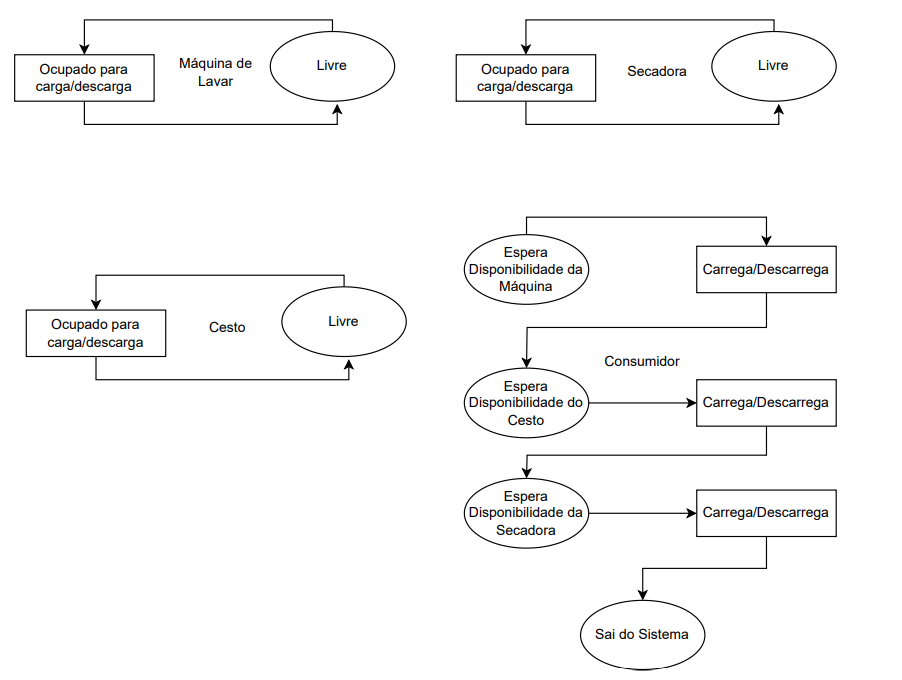

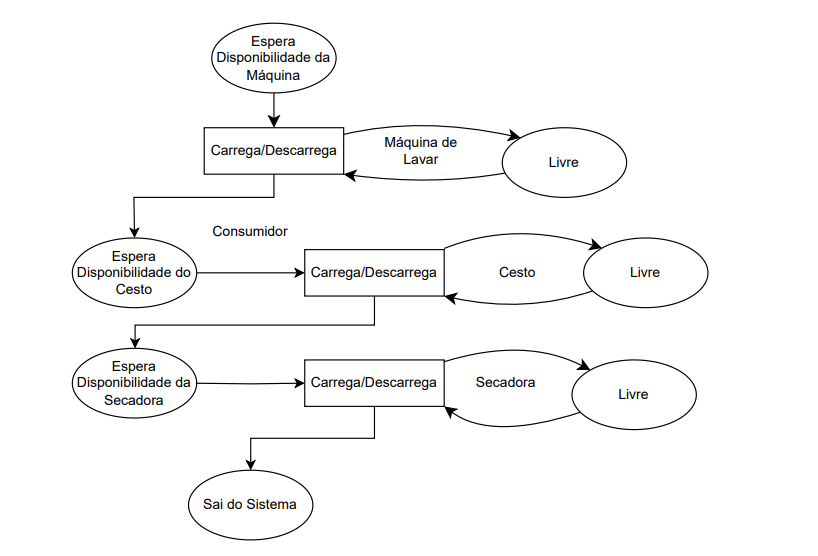

### Código

In [2]:
import random
import simpy
import statistics
import seaborn as sns
import pandas as pd
import time

from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Prep time

In [5]:
df_times = pd.read_excel('intervalos_chegada_lavanderia.xlsx')

MovieWriter ffmpeg unavailable; using Pillow instead.


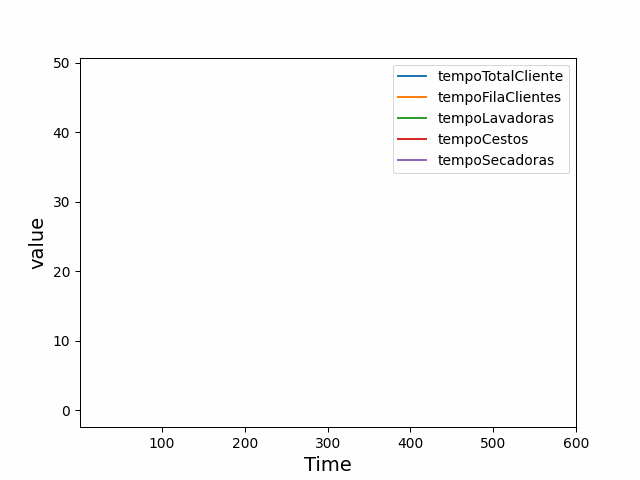

In [7]:
contaClientes = 0             # conta clientes que chegaram no sistema

tempoPercorrido = []
tempoTotalCliente = [] #done
tempoFilaClientes = [] #done
tempoLavadoras = [] #done
tempoCestos = [] #done
tempoSecadoras = [] #done


time_dict = {
    'tempoPercorrido': tempoPercorrido,
    'tempoTotalCliente': tempoTotalCliente,
    'tempoFilaClientes': tempoFilaClientes,
    'tempoLavadoras': tempoLavadoras,
    'tempoCestos': tempoCestos,
    'tempoSecadoras': tempoSecadoras
}



def distributions(tipo):
    # função que armazena as distribuições utilizadas no modelo
    return {
        'chegadas': random.expovariate(1.0/10.0),
        'lavar': 25,
        'descarregar': random.uniform(1, 4),
        'carregar': 2,
        'transportar': random.uniform(3,5),
        'secar': random.uniform(9, 12),
    }.get(tipo, 0.0)

def chegadaClientes(env, lavadoras, cestos, secadoras):
    # função que gera a chegada de clientes
    global contaClientes
    while True:
        yield env.timeout(distributions('chegadas'))
        contaClientes += 1
        #print(f"Cliente {contaClientes} chega em: {env.now}")
        

    # chamada do processo de lavagem e secagem
        env.process(lavaSeca(env, contaClientes, lavadoras, cestos, secadoras))

def lavaSeca(env, cliente, lavadoras, cestos, secadoras):
    # função que processa a operação de cada cliente dentro da lavanderia
    inicio_geral = env.now

    inicio_fila = env.now

    
    # ocupa a lavadora
    req_lavadora = lavadoras.request()
    yield req_lavadora
    inicio_lavar = env.now
    #print(f'Lavadora inicia a lavagem do Cliente {cliente} as: {env.now}')
    
    termino_fila = env.now - inicio_fila
    
    
    yield env.timeout(distributions('lavar'))
    termino_lavar = env.now - inicio_lavar
    
    
    # antes de retirar da lavadora, pega um cesto
    req_cesto = cestos.request()
    yield req_cesto
    inicio_cesto = env.now
    #print(f'Cliente {cliente} ocupa o cesto as: {env.now}')
    #print(f'Cliente {cliente} inicia o descarregamento da maquina as: {env.now}')
    yield env.timeout(distributions('descarregar'))
    

    # libera a lavadora, mas não o cesto
    yield lavadoras.release(req_lavadora)
    #print(f'Cliente {cliente} desocupa a lavadora as: {env.now}')
    
    # cliente trasporta o cesto ate a maquina de secar
    #print(f'Cliente inicia o transporte das roupas para a máquina de secar as: {env.now}')
    yield env.timeout(distributions('transportar'))
    #print(f'Cliente terminar o transporte das roupas para a máquina de secar as: {env.now}')
    
    # ocupa a secadora antes de liberar o cesto
    req_secadora = secadoras.request()
    yield req_secadora
    inicio_secadoras = env.now
    #print(f'Cliente {cliente} ocupa a secadora as: {env.now}')
    yield env.timeout(distributions('carregar'))
    
    # libera o cesto mas não a secadora
    yield cestos.release(req_cesto)
    termino_cesto = env.now - inicio_cesto
    
    #print(f'Cliente {cliente} desocupa o cesto as: {env.now}')
    yield env.timeout(distributions('secar'))
    
    # pode liberar a secadora
    #print(f'Cliente {cliente} iniciar o descarregamento da secadora as: {env.now}')
    yield env.timeout(distributions('descarregar'))	
    
    yield secadoras.release(req_secadora)
    termino_secadoras = env.now - inicio_secadoras
    
    
    termino_geral = env.now - inicio_geral
    
    #print(f'Cliente {cliente} desocupa o secadora as: {env.now}')
    
    tempoSecadoras.append(termino_secadoras)
    tempoTotalCliente.append(termino_geral)
    tempoCestos.append(termino_cesto)
    tempoLavadoras.append(termino_lavar)
    tempoFilaClientes.append(termino_fila)
    tempoPercorrido.append(env.now)
    

    

random.seed(10)
env = simpy.Environment()
lavadoras = simpy.Resource(env, capacity=7)
cestos = simpy.Resource(env, capacity=12)
secadoras = simpy.Resource(env, capacity=1)
env.process(chegadaClientes(env, lavadoras, cestos, secadoras))

env.run(until=600)

df = pd.DataFrame(data=time_dict)
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    x_labels = df['tempoPercorrido'][:i+1]
    ax.set_xlim([1, 600])
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('value', fontsize=14)
    sns.lineplot(x=x_labels, y=df['tempoTotalCliente'][:i+1], ax=ax, label='tempoTotalCliente')
    sns.lineplot(x=x_labels, y=df['tempoFilaClientes'][:i+1], ax=ax, label='tempoFilaClientes')
    sns.lineplot(x=x_labels, y=df['tempoLavadoras'][:i+1], ax=ax, label='tempoLavadoras')
    sns.lineplot(x=x_labels, y=df['tempoCestos'][:i+1], ax=ax, label='tempoCestos')
    sns.lineplot(x=x_labels, y=df['tempoSecadoras'][:i+1], ax=ax, label='tempoSecadoras')
    


plt.close()
#plt.show()
anim = animation.FuncAnimation(fig, animate, frames=len(df)*2)
anim.save('test.gif')
Image("test.gif")
